In [1]:
import string
import heapq

from IPython.display import clear_output

In [2]:
%run rnn/generate.py

In [3]:
decoder = torch.load('rnn/rnn_model.pt')

In [4]:
decoder

CharRNN (
  (encoder): Embedding(100, 100)
  (rnn): GRU(100, 100, num_layers=2)
  (decoder): Linear (100 -> 100)
)

In [15]:
generate(decoder, prime_str='christmas ', predict_len=200)

"christmas walk movies is trying. days to production on this movie was rankes it is the set in the views and director is seen the stume and nature which is a lead this is those off the movie easy with comedy's w"

In [6]:
%time srtd, indices = torch.topk(distribution(decoder, prime_str='however we need a'), 3)

CPU times: user 48 ms, sys: 1.98 ms, total: 50 ms
Wall time: 39.7 ms


(<matplotlib.lines.Line2D at 0x1218086d8>,)

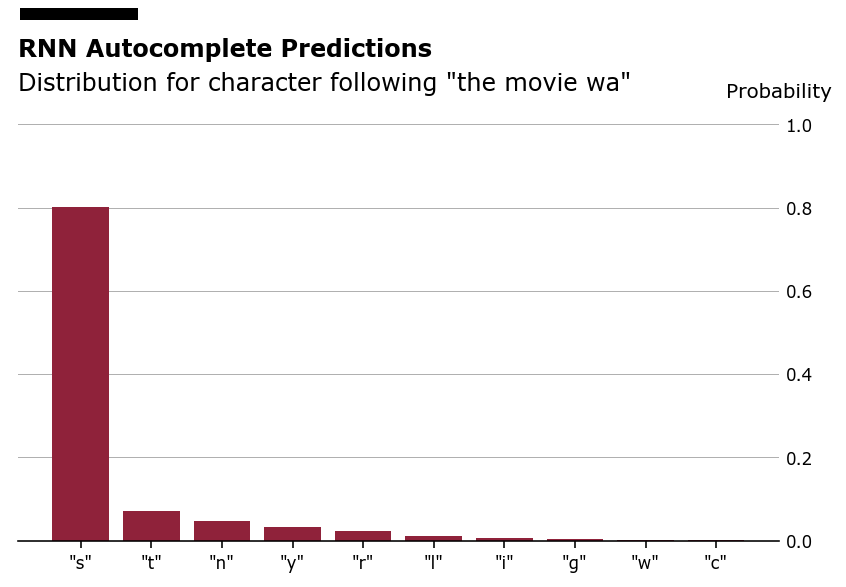

In [88]:
n = 10
s = "the movie wa"

srtd, indices = torch.topk(distribution(decoder, prime_str=s), 10)
plt.bar(range(n), srtd)

plt.xticks(range(n), ['"' + string.printable[indices[i]] + '"' for i in range(n)]);
plt.yticks(np.arange(0,1.1,.2))
plt.ylim((0,1.1))
plt.ylabel('Probability')

ft_ax(title='RNN Autocomplete Predictions', 
      subtitle='Distribution for character following "%s"' % s, 
      add_box=True)

In [10]:
s = "start revie"

In [11]:
%time srtd, indices = torch.topk(distribution(decoder, prime_str=s), 3)

CPU times: user 28.8 ms, sys: 1.68 ms, total: 30.5 ms
Wall time: 25.7 ms


In [13]:
f = open('case_data/reviews_8.txt', 'r')

In [73]:
l = f.readline().lower()

In [86]:
%%time
%run rnn/generate.py
i = 1
counter = 0
eliminated = []
preds = []

while i < len(l):
    counter += 1
    
    eliminated = [s[len(next_chars):] for s in eliminated + preds
                  if s[:len(next_chars)] == next_chars]

    
    if i == 1:
        preds, hidden = predict(l[:i], decoder, output_hidden=True)
    else:
        preds, hidden = predict(l[:i], 
                                decoder, 
                                hidden=hidden, 
                                hidden_lag=max(len(correct_pred), 1), 
                                eliminated=eliminated,
                                output_hidden=True)
    correct_pred = ''
    
    for pred in sorted(preds, key=lambda x:len(x), reverse=True):
        if l[i:].startswith(pred):
            correct_pred = pred
            break
    
    print (l[max(0,i-15):i] + '[' + correct_pred + ']')
    for pred in preds:
        print('"%s"' % pred)
    next_chars = l[i:i+max(len(correct_pred), 1)]
    i += max(len(correct_pred), 1)
    #time.sleep(.5)
    clear_output(wait=True)

print(counter)


1194
CPU times: user 2min 6s, sys: 2.65 s, total: 2min 9s
Wall time: 1min 14s


In [77]:
1213

'paul greengrass, mark this name.... how can the studio approve such a lame picture? this movie is a swindle from beginning to end. why? let me explain.  we had a previously decent, intriguing, sometimes exciting spy action thriller with the bourne identity. what do we hav in this sequence? let me answer:  1) zero suspense. you can miles ahead who is (are) the bad guys. absolutely nothing like the first movie.  2) how can a director, on purpose, decide to shoot a film in such an obnoxious way, using a hand camera all along the way, and ordering his cameramen to shake it, shake it,  and shake it once more, and then goes into the editor\'s room and orders the editor to cut from frame to frame in less than a second, along the whole movie. it\'s not only in the action scenes. it\'s in the whole movie! it\'s something to wonder when a director shows such contempt for his audience, not showing one single fight sequence in a way that we could follow! and, even doing so, he receives a lot of r

In [240]:
%time predict(l[:1000])

CPU times: user 1.8 s, sys: 40.5 ms, total: 1.84 s
Wall time: 987 ms


['th', 'the ', 'the']

In [287]:
import time

In [302]:
%%time
times = {}
for i in range(10,1000,3):
    start = time.clock()
    predict(l[:i])
    times[i] = time.clock() - start

CPU times: user 2min 41s, sys: 2.12 s, total: 2min 43s
Wall time: 1min 33s


(<matplotlib.lines.Line2D at 0x11b00ed30>,)

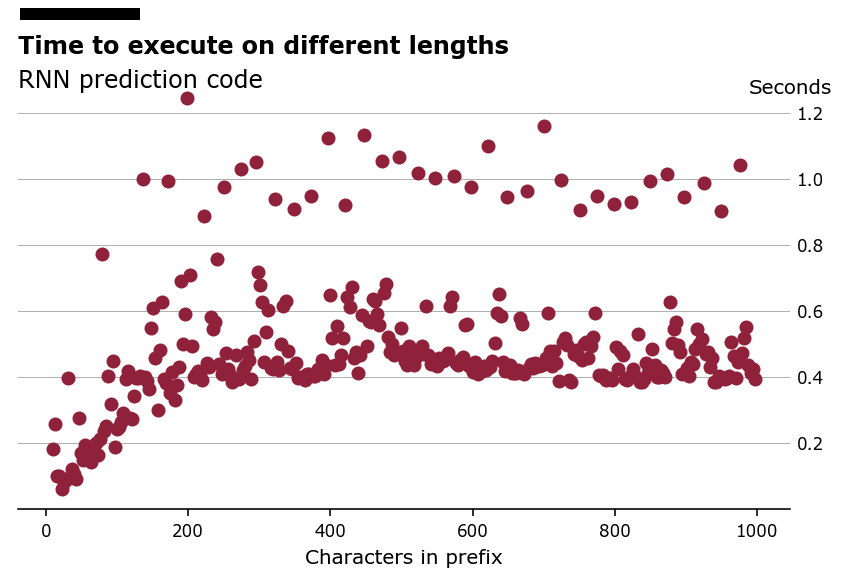

In [304]:
plt.plot(pd.Series(times), 'o')
plt.ylabel('Seconds')
plt.xlabel('Characters in prefix')
ft_ax(title='Time to execute on different lengths', 
      subtitle='RNN prediction code', 
      add_box=True)

In [35]:
def predict(s, decoder, hidden=None, hidden_lag=1, output_hidden=False):
    """
    If hidden state is given, it should not be for the full string
    """
    probs = [{'': 1},]
    scores = [(0,''),(0, ' '), (0,'e')]
    heapq.heapify(scores)

    is_useful = True
    while len(probs) <= 2 or is_useful:
        new_guesses = []
        for guess in probs[-1].keys():
            running_str = s + guess
            if guess != '':
                srtd, indices = torch.topk(distribution(
                    decoder, prime_str=guess, hidden=hidden), 3)
            else:
                if hidden is not None:
                    distr, hidden = distribution(decoder,
                                                 prime_str=s[-hidden_lag:], 
                                                 hidden=hidden,
                                                 output_hidden=True)
                else:
                    distr, hidden = distribution(decoder, s, output_hidden=True)
                srtd, indices = torch.topk(distr, 3)

            for val, i in zip(srtd, indices):
                if len(new_guesses) == 3:
                    heapq.heappushpop(new_guesses,
                        (probs[-1][guess] * val, guess + string.printable[i]))
                else:
                    heapq.heappush(new_guesses,
                        (probs[-1][guess] * val, guess + string.printable[i]))
        probs.append({})
        is_useful = False
        for val, guess in new_guesses:
            probs[-1][guess] = val
            if val*(len(guess)-1) > scores[0][0]:
                heapq.heappushpop(scores, (val*(len(guess)-1), guess))
                is_useful = True
    
    if not output_hidden:
        return [x[1] for x in scores]
    else:
        return [x[1] for x in scores], hidden


In [51]:
blacklist = set(['a', 'b', 'c'])

In [49]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [55]:
black = [1, 3]

In [53]:
testx = torch.zeros(10)

In [59]:
testx[torch.LongTensor(black)] = 1

In [60]:
testx


 0
 1
 0
 1
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 10]

In [70]:
type(testx)

torch.FloatTensor